# RSI momentum trading strategy example

- This is a backtest example notebook
    - Compare price and data for two different trading hour cycles
    - It is based on the previous notebook, and we pick two particular grid search results for the comparison
    - We compare "good" (optional) and "bad" (clockshifted) results
    - The clockshifted result has its trading pair candles shifted 0..23 hours

# Set up

Set up Trading Strategy data client.


In [1]:
from tradeexecutor.utils.notebook import setup_charting_and_output
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

# Render for Github web viewer
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)
#setup_charting_and_output(width=1500, height=1000)

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Load data

We use Binance data so we get a longer period of data.

In [2]:
import datetime
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.utils.binance import create_binance_universe

strategy_universe = create_binance_universe(
    ["BTCUSDT", "ETHUSDT"],   # Binance internal tickers later mapped to Trading strategy DEXPair metadata class
    candle_time_bucket=TimeBucket.h1,
    stop_loss_time_bucket=TimeBucket.h1,
    start_at=datetime.datetime(2019, 1, 1),  # Backtest for 5 years data
    end_at=datetime.datetime(2024, 1, 1),
    include_lending=False
)


  0%|          | 0/2 [00:00<?, ?it/s]

# Show loaded trading universe

Display generic troubleshooting information about the loaded data.

In [3]:
pairs = strategy_universe.data_universe.pairs  # Trading pairs metadata
candles = strategy_universe.data_universe.candles  # Candles for all trading pairs

print(f"Loaded {candles.get_candle_count():,} candles.")

for pair in pairs.iterate_pairs():
    pair_candles = candles.get_candles_by_pair(pair)
    first_close = pair_candles.iloc[0]["close"]
    first_close_at = pair_candles.index[0]
    print(f"Pair {pair} first close price {first_close} at {first_close_at}")

Loaded 87,650 candles.
Pair <Pair #1 BTC - USDT at exchange binance> first close price 3700.31 at 2019-01-01 00:00:00
Pair <Pair #2 ETH - USDT at exchange binance> first close price 131.82 at 2019-01-01 00:00:00


# Trading algorithm

In [4]:
from tradingstrategy.utils.groupeduniverse import resample_candles
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.weighting import weight_equal, weight_by_1_slash_n, weight_passthrouh
from tradeexecutor.strategy.alpha_model import AlphaModel
import numpy as np
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradingstrategy.chain import ChainId
from typing import List, Dict

from pandas_ta.momentum import rsi
import pandas as pd

from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.state.visualisation import PlotKind, PlotShape, PlotLabel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pricing_model import PricingModel
from tradeexecutor.state.state import State

# List of pair descriptions we used to look up pair metadata
our_pairs = [
    (ChainId.centralised_exchange, "binance", "BTC", "USDT"),
    (ChainId.centralised_exchange, "binance", "ETH", "USDT"),
]

def decide_trades(
    timestamp: pd.Timestamp,
    parameters: StrategyParameters,
    strategy_universe: TradingStrategyUniverse,
    state: State,
    pricing_model: PricingModel,
) -> List[TradeExecution]:
    
    # Execute the daily trade cycle when the clock hour 0..24 is correct for our hourly shift
    if (parameters.cycle - 1 - parameters.shift) % 24 != 0:
        return []

    # Resolve our pair metadata for our two pair strategy
    position_manager = PositionManager(timestamp, strategy_universe, state, pricing_model)
    alpha_model = AlphaModel(timestamp)
    btc_pair = position_manager.get_trading_pair(our_pairs[0])
    eth_pair = position_manager.get_trading_pair(our_pairs[1])
    position_manager.log("decide_trades() start")

    #
    # Indicators
    #
    # Calculate indicators for each pair.
    #

    # Per-trading pair calcualted data
    close_prices = {btc_pair: None, eth_pair: None}  # Recent close prices
    current_rsi_values = {}  # RSI yesterday
    previous_rsi_values = {}  # RSI day before yesterday
    current_price = {}  # Close price yesterday
    momentum = {btc_pair: 0, eth_pair: 0}
    eth_btc_rsi_yesterday = None

    for pair in [btc_pair, eth_pair]:

        # Get all candles and shift candles left
        raw_pair_candles = candles.get_last_entries_by_pair_and_timestamp(pair.internal_id, timestamp)
        pair_candles = resample_candles(raw_pair_candles, TimeBucket.d1.to_pandas_timedelta(), shift=-parameters.shift)

        close_prices[pair] = pair_candles["close"]

        assert pair_candles is not None
        rsi_series = rsi(pair_candles["close"], length=parameters.rsi_bars)  # Will return None if the data buffer does not have enough days to look back

        # Reset indicators for this cycle and this pair
        current_rsi_values[pair] = None
        previous_rsi_values[pair] = None
        current_price[pair] = None
        price_today = None

        if len(pair_candles) > 0:
            # We have enough data to get the latest price
            current_price[pair] = price_today = pair_candles["close"][-1]

        if rsi_series is not None:
            current_val = rsi_series[-1]
            if np.isfinite(current_val):
                # We have enough data and good value for RSI
                assert 0 < current_val < 100, f"RSI sanity check failed: {pair}: {current_val}"  # Check we are in expected range
                current_rsi_values[pair] = current_val

            previous_val = rsi_series[-2]
            if np.isfinite(previous_val):
                # We have enough data and good value for RSI
                assert 0 < previous_val < 100, f"RSI sanity check failed: {pair}: {previous_val}"  # Check we are in expected range
                previous_rsi_values[pair] = previous_val

            previous_rsi_values[pair] = previous_val

    eth_btc_price = close_prices[eth_pair] / close_prices[btc_pair]
    eth_btc_rsi = rsi(eth_btc_price, length=parameters.eth_btc_rsi_bars)
    if eth_btc_rsi is not None:
        eth_btc_rsi_yesterday = eth_btc_rsi[-1]
        momentum[eth_pair] = (eth_btc_rsi_yesterday - 50) ** 3
        momentum[btc_pair] = (50 - momentum[eth_pair]) ** 3

    #
    # Trading logic
    #

    for pair in [btc_pair, eth_pair]:

        existing_position = position_manager.get_current_position_for_pair(pair)
        pair_open = existing_position is not None
        pair_momentum = momentum.get(pair, 0)
        signal_strength = max(pair_momentum, 0.1)  # Singal strength must be positive, as we do long-only
        if pd.isna(signal_strength):
            signal_strength = 0
        alpha_model.set_signal(pair, 0)

        if pair_open:
            # We have existing open position for this pair,
            # keep it open by default unless we get a trigger condition below
            position_manager.log(f"Pair {pair} already open")
            alpha_model.set_signal(pair, signal_strength, trailing_stop_loss=parameters.trailing_stop_loss)

        if current_rsi_values[pair] and previous_rsi_values[pair]:

            # Check for RSI crossing our threshold values in this cycle, compared to the previous cycle
            rsi_cross_above = current_rsi_values[pair] >= parameters.rsi_high and previous_rsi_values[btc_pair] < parameters.rsi_high
            rsi_cross_below = current_rsi_values[pair] < parameters.rsi_low and previous_rsi_values[pair] > parameters.rsi_low

            if not pair_open:
                # Check for opening a position if no position is open
                if rsi_cross_above:
                    position_manager.log(f"Pair {pair} crossed above")
                    alpha_model.set_signal(pair, signal_strength, trailing_stop_loss=parameters.trailing_stop_loss)
            else:
                # We have open position, check for the closure condition
                if rsi_cross_below:
                    position_manager.log(f"Pair {pair} crossed below")
                    alpha_model.set_signal(pair, 0)

    # Equally weight for all assets that
    alpha_model.select_top_signals(2)
    alpha_model.assign_weights(weight_passthrouh)
    alpha_model.normalise_weights()
    alpha_model.update_old_weights(state.portfolio)
    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity() * parameters.allocation
    alpha_model.calculate_target_positions(position_manager, portfolio_target_value)
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=parameters.minimum_rebalance_trade_threshold,
    )

    #
    # Visualisations
    #

    visualisation = state.visualisation  # Helper class to visualise strategy output

    visualisation.plot_indicator(
        timestamp,
        f"ETH",
        PlotKind.technical_indicator_detached,
        current_price[eth_pair],
        colour="blue",
    )

    # Draw BTC + ETH RSI between its trigger zones for this pair of we got a valid value for RSI for this pair

    # BTC RSI daily
    visualisation.plot_indicator(
        timestamp,
        f"RSI",
        PlotKind.technical_indicator_detached,
        current_rsi_values[btc_pair],
        colour="orange",
    )

    # ETH RSI daily
    visualisation.plot_indicator(
        timestamp,
        f"RSI ETH",
        PlotKind.technical_indicator_overlay_on_detached,
        current_rsi_values[eth_pair],
        colour="blue",
        label=PlotLabel.hidden,
        detached_overlay_name=f"RSI",
    )

    # Low (vertical line)
    visualisation.plot_indicator(
        timestamp,
        f"RSI low trigger",
        PlotKind.technical_indicator_overlay_on_detached,
        parameters.rsi_low,
        detached_overlay_name=f"RSI",
        plot_shape=PlotShape.horizontal_vertical,
        colour="red",
        label=PlotLabel.hidden,
    )

    # High (vertical line)
    visualisation.plot_indicator(
        timestamp,
        f"RSI high trigger",
        PlotKind.technical_indicator_overlay_on_detached,
        parameters.rsi_high,
        detached_overlay_name=f"RSI",
        plot_shape=PlotShape.horizontal_vertical,
        colour="red",
        label=PlotLabel.hidden,
    )

    if eth_btc_rsi_yesterday is not None:

        visualisation.plot_indicator(
            timestamp,
            f"ETH/BTC",
            PlotKind.technical_indicator_detached,
            eth_btc_price[-1],
            colour="grey",
        )

        if pd.notna(eth_btc_rsi_yesterday):
            visualisation.plot_indicator(
                timestamp,
                f"ETH/BTC RSI",
                PlotKind.technical_indicator_detached,
                eth_btc_rsi_yesterday,
                colour="grey",
            )

    state.visualisation.add_calculations(timestamp, alpha_model.to_dict())  # Record alpha model thinking

    return trades

/Users/moo/Library/Caches/pypoetry/virtualenvs/trade-executor-8Oz1GdY1-py3.10/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



# Search space

Prepare the parameters we search.

In [5]:
from tradeexecutor.strategy.cycle import CycleDuration
from pathlib import Path
from tradeexecutor.backtest.grid_search import prepare_grid_combinations

# This is the path where we keep the result files around
storage_folder = Path("/tmp/v10-grid-search-short-term-shift")

class ParametersGood:
    cycle_duration = CycleDuration.cycle_1h
    rsi_bars = 5
    eth_btc_rsi_bars = 20  # The length of ETH/BTC RSI
    rsi_high = 77 # RSI trigger threshold for decision making
    rsi_low = 60  # RSI trigger threshold for decision making
    allocation = 0.85 # Allocate 90% of cash to each position
    lookback_candles = 140
    minimum_rebalance_trade_threshold = 500.00  # Don't do trades that would have less than 500 USD value change
    initial_cash = 10_000 # Start with 10k USD
    trailing_stop_loss = 0.875
    shift = 0


# We introduce 23 hours clock shift which will totally ruin our strategy performance results
class ParametersBad:
    cycle_duration = CycleDuration.cycle_1h
    rsi_bars = 5
    eth_btc_rsi_bars = 20  # The length of ETH/BTC RSI
    rsi_high = 77 # RSI trigger threshold for decision making
    rsi_low = 60  # RSI trigger threshold for decision making
    allocation = 0.85 # Allocate 90% of cash to each position
    lookback_candles = 140
    minimum_rebalance_trade_threshold = 500.00  # Don't do trades that would have less than 500 USD value change
    initial_cash = 10_000 # Start with 10k USD
    trailing_stop_loss = 0.875
    shift = 1



# Backtest

Backtest with with both parameter sets.
- Good fitted parameters
- Bad outcome with a clock shift of 23 hours

In [6]:
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.backtest.backtest_runner import run_backtest_inline

bad_state, _, _ = run_backtest_inline(
    name="RSI multipair (bad outcome)",
    engine_version="0.4",
    decide_trades=decide_trades,
    client=client,
    universe=strategy_universe,
    parameters=ParametersBad,
    strategy_logging=False,
)

trade_count = len(list(bad_state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

  0%|          | 0/157766400 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 184 trades


In [7]:

from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.backtest.backtest_runner import run_backtest_inline

good_state, _, _ = run_backtest_inline(
    name="RSI multipair (good outcome)",
    engine_version="0.4",
    decide_trades=decide_trades,
    client=client,
    universe=strategy_universe,
    parameters=ParametersGood,
    strategy_logging=False,
)

trade_count = len(list(good_state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

  0%|          | 0/157766400 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 203 trades


# Comparison

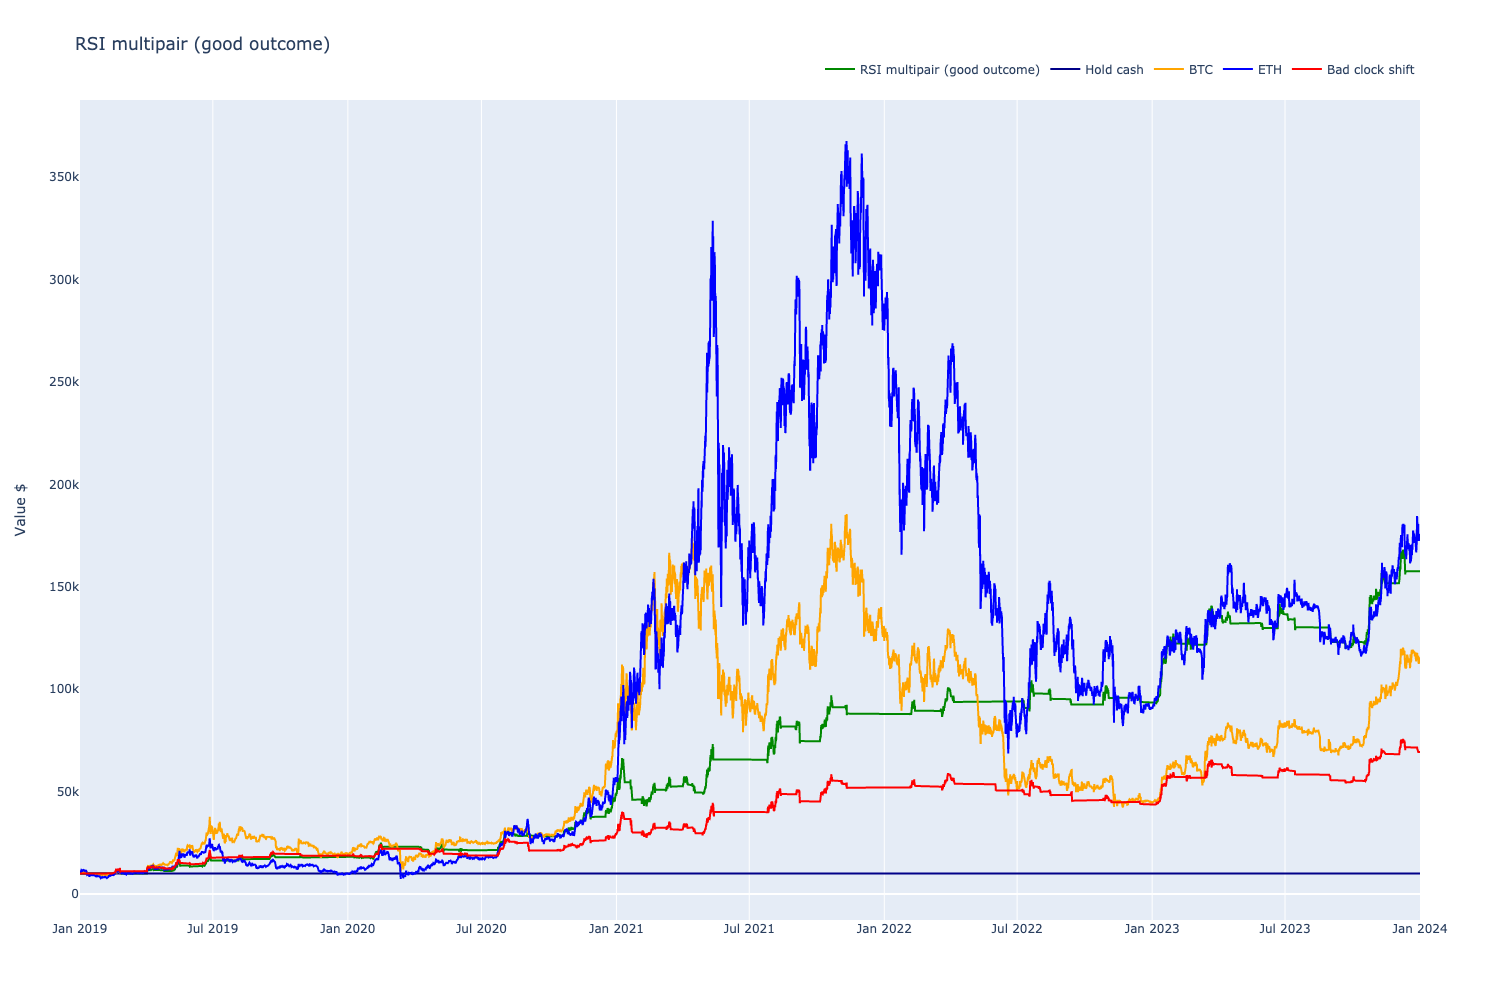

In [8]:
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark
from tradeexecutor.visual.equity_curve import calculate_equity_curve

btc_pair = strategy_universe.data_universe.pairs.get_pair_by_human_description(our_pairs[0])
eth_pair = strategy_universe.data_universe.pairs.get_pair_by_human_description(our_pairs[1])

bad_result = calculate_equity_curve(bad_state)

benchmark_indexes = pd.DataFrame({
    "BTC": strategy_universe.data_universe.candles.get_candles_by_pair(btc_pair)["close"],
    "ETH": strategy_universe.data_universe.candles.get_candles_by_pair(eth_pair)["close"],
    "Bad clock shift": bad_result,
})
benchmark_indexes["BTC"].attrs = {"colour": "orange"}
benchmark_indexes["ETH"].attrs = {"colour": "blue", "name": "Buy and hold ETH"}
benchmark_indexes["Bad clock shift"].attrs = {"colour": "red", "name": "Strategy with bad clock shift"}

fig = visualise_equity_curve_benchmark(
    name=good_state.name,
    portfolio_statistics=good_state.stats.portfolio,
    all_cash=good_state.portfolio.get_initial_deposit(),
    benchmark_indexes=benchmark_indexes,
    height=800
)

fig.show()

## Price overlay



Optimal  Benchmark
timestamp                              
2019-01-01 00:00:00   139.10        NaN
2019-01-01 01:00:00      NaN     138.92
2019-01-02 00:00:00   152.01        NaN
2019-01-02 01:00:00      NaN     149.40
2019-01-03 00:00:00   146.30        NaN
...                      ...        ...
2023-12-29 01:00:00      NaN    2302.07
2023-12-30 00:00:00  2291.68        NaN
2023-12-30 01:00:00      NaN    2301.03
2023-12-31 00:00:00      NaN        NaN
2023-12-31 01:00:00      NaN        NaN

[3652 rows x 2 columns]

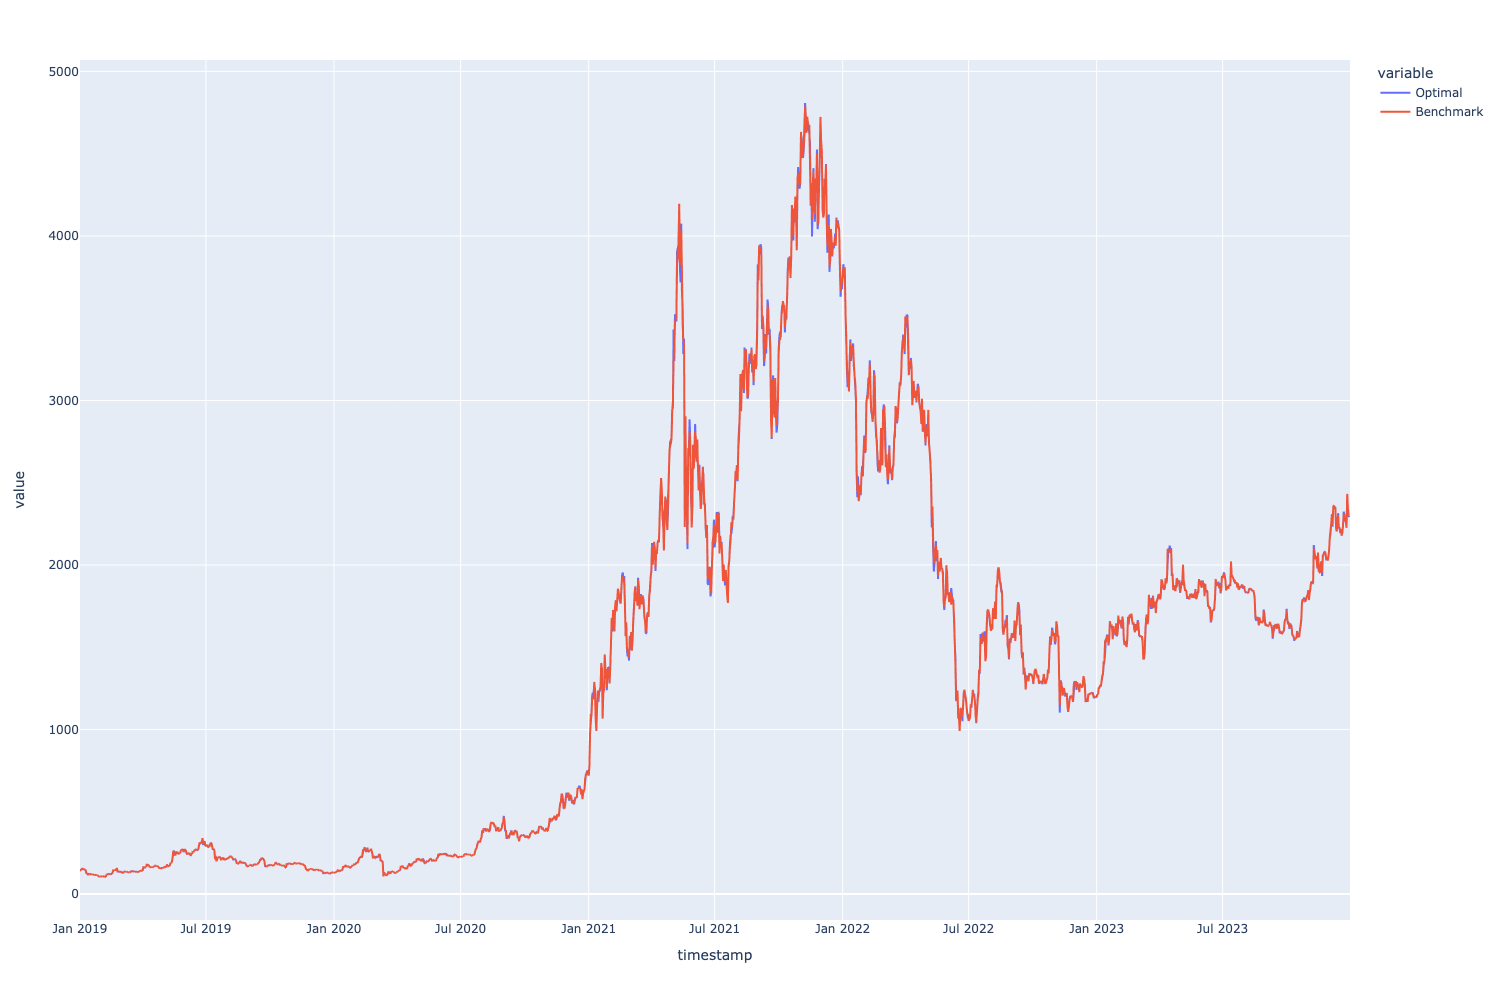

In [9]:
import plotly.express as px

from tradeexecutor.visual.technical_indicator import export_plot_as_dataframe

good_price = export_plot_as_dataframe(good_state.visualisation.plots["ETH"])
bad_price = export_plot_as_dataframe(bad_state.visualisation.plots["ETH"])

df = pd.DataFrame({
    "Optimal": good_price["value"],
    "Benchmark": bad_price["value"]
})

display(df)

fig = px.line(df)
fig.update_traces(connectgaps=True)
fig.show()

## RSI overlay



Optimal  Benchmark
timestamp                                
2019-01-01 00:00:00        NaN        NaN
2019-01-01 01:00:00        NaN        NaN
2019-01-02 00:00:00        NaN        NaN
2019-01-02 01:00:00        NaN        NaN
2019-01-03 00:00:00        NaN        NaN
...                        ...        ...
2023-12-29 01:00:00        NaN  37.983261
2023-12-30 00:00:00  37.946881        NaN
2023-12-30 01:00:00        NaN  43.275706
2023-12-31 00:00:00        NaN        NaN
2023-12-31 01:00:00        NaN        NaN

[3652 rows x 2 columns]

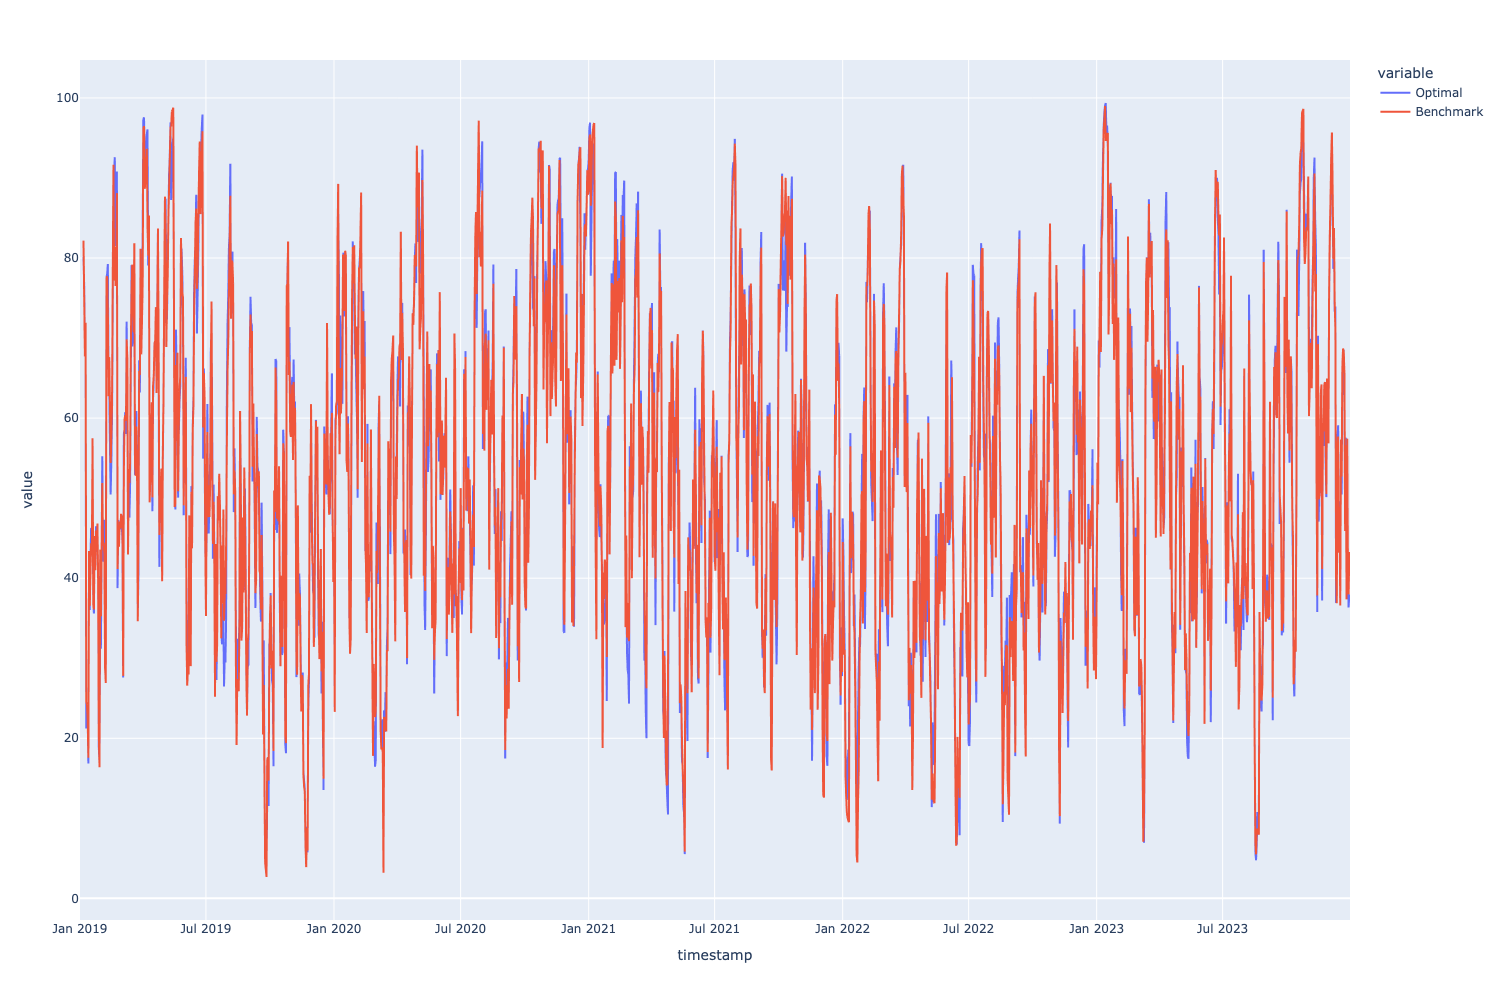

In [10]:

good_rsi = export_plot_as_dataframe(good_state.visualisation.plots["RSI"])
bad_rsi = export_plot_as_dataframe(bad_state.visualisation.plots["RSI"])

df = pd.DataFrame({
    "Optimal": good_rsi["value"],
    "Benchmark": bad_rsi["value"]
})

display(df)

fig = px.line(df)
fig.update_traces(connectgaps=True)
fig.show()

# Price action comparison



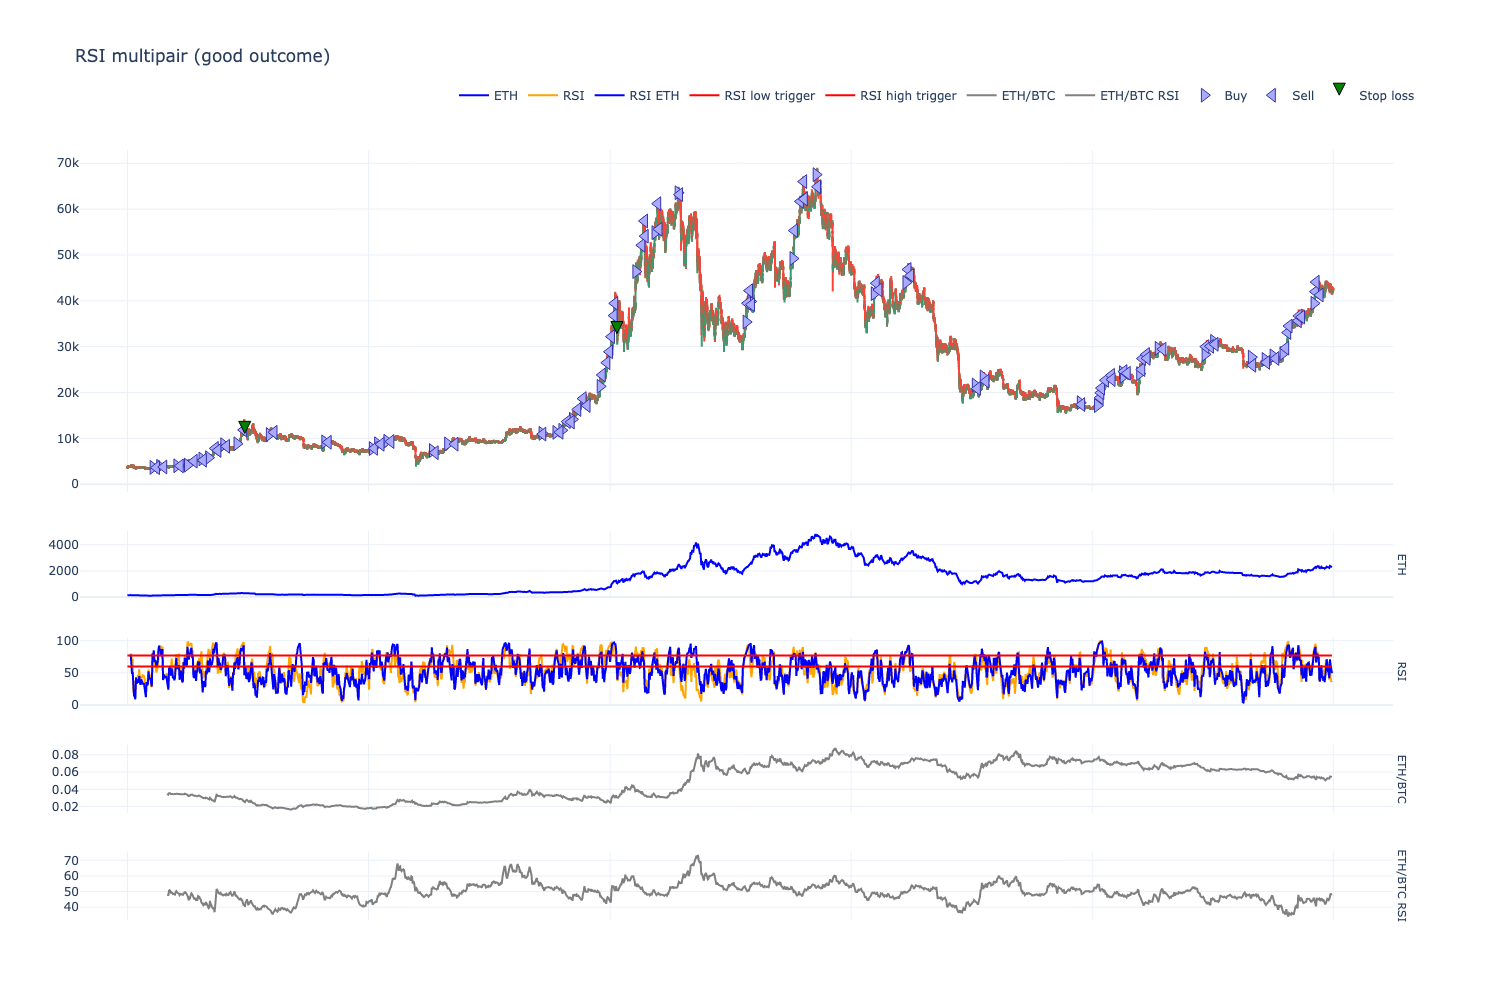

In [11]:
from tradeexecutor.visual.single_pair import visualise_single_pair
from tradingstrategy.charting.candle_chart import VolumeBarMode

# Use BTC pair as the primary price source
# Get BTC pair
btc_pair = pairs.get_pair_by_human_description(our_pairs[0])

figure = visualise_single_pair(
    good_state,
    strategy_universe.data_universe.candles,
    pair_id=btc_pair.pair_id,
    volume_bar_mode=VolumeBarMode.hidden,
    height = 2000,
)

figure.show()

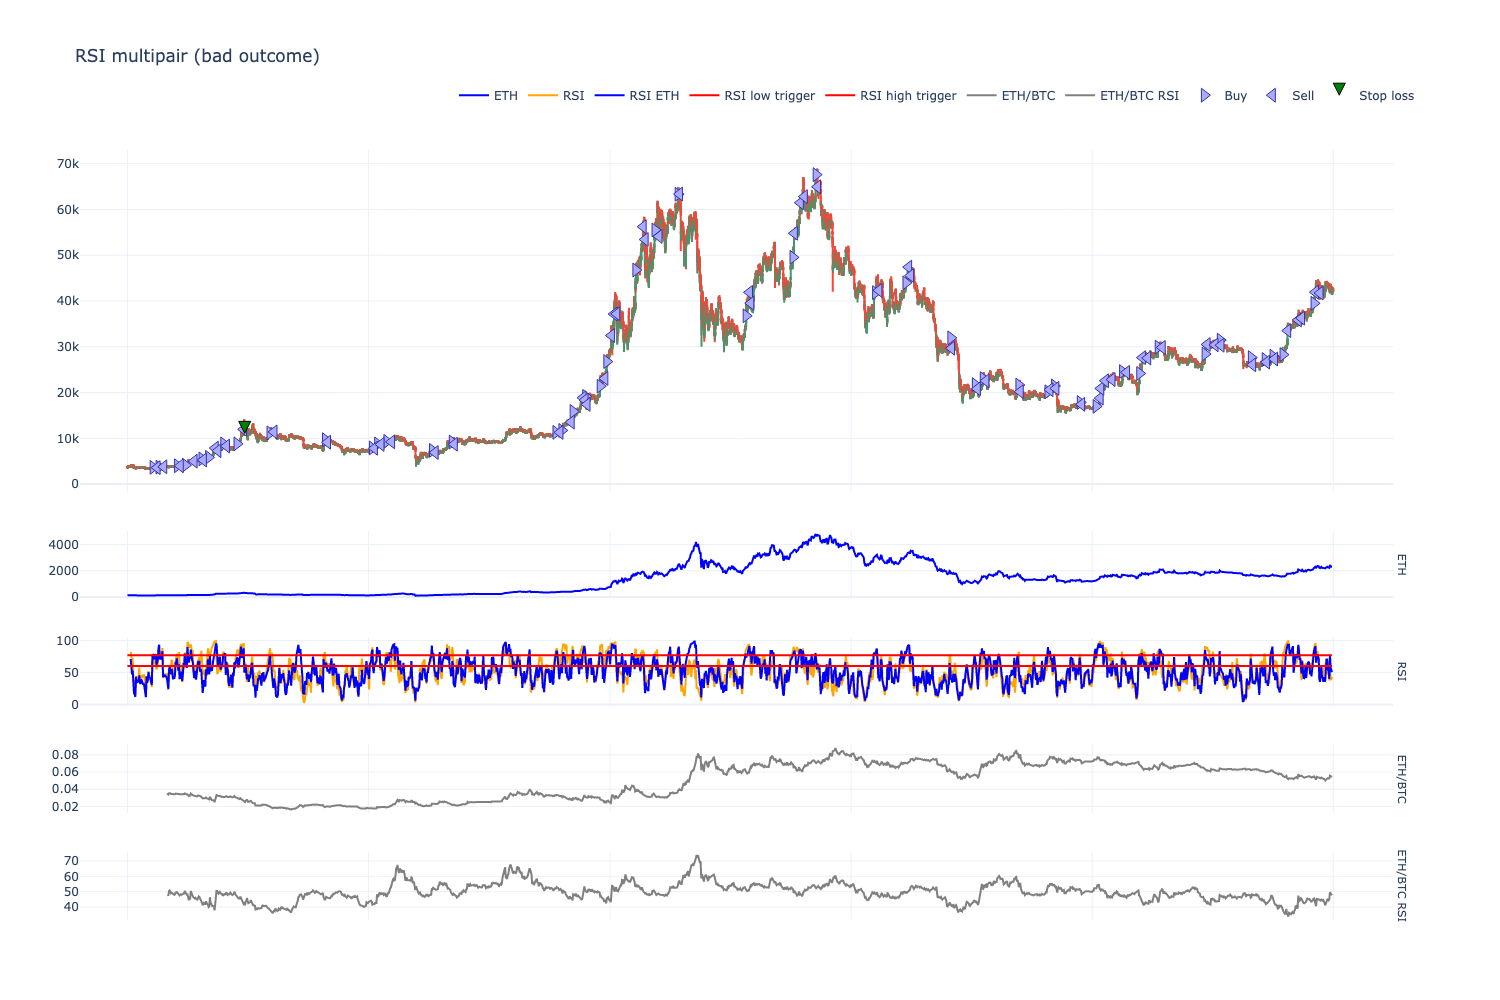

In [12]:
from tradeexecutor.visual.single_pair import visualise_single_pair
from tradingstrategy.charting.candle_chart import VolumeBarMode

# Use BTC pair as the primary price source
# Get BTC pair
btc_pair = pairs.get_pair_by_human_description(our_pairs[0])

figure = visualise_single_pair(
    bad_state,
    strategy_universe.data_universe.candles,
    pair_id=btc_pair.pair_id,
    volume_bar_mode=VolumeBarMode.hidden,
    height = 2000,
)

figure.show()

In [13]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns, generate_buy_and_hold_returns
from tradeexecutor.analysis.advanced_metrics import visualise_advanced_metrics, AdvancedMetricsMode

good_equity = calculate_equity_curve(good_state)
good_returns = calculate_returns(good_equity)

bad_equity = calculate_equity_curve(bad_state)
bad_returns = calculate_returns(bad_equity)
bad_returns.attrs["name"] = "Clockshifted results"


metrics = visualise_advanced_metrics(
    good_returns,
    mode=AdvancedMetricsMode.full,
    benchmark=bad_returns,
)

display(metrics)

Strategy Clockshifted results
Start Period               2019-01-01           2019-01-01
End Period                 2023-12-31           2023-12-31
Risk-Free Rate                   0.0%                 0.0%
Time in Market                  27.0%                28.0%
Cumulative Return           1,476.08%              593.37%
CAGR﹪                          73.59%                47.3%
Sharpe                           0.37                 0.27
Prob. Sharpe Ratio             100.0%               99.83%
Smart Sharpe                     0.36                 0.26
Sortino                          0.52                 0.38
Smart Sortino                    0.51                 0.37
Sortino/√2                       0.37                 0.27
Smart Sortino/√2                 0.36                 0.26
Omega                            1.13                 1.13
Max Drawdown                  -35.51%              -31.66%
Longest DD Days                   225                  306
Volatility (ann.)               6.82%                6.85%
R^2                              0.89                 0.89
Information Ratio                0.02                 0.02
Calmar                           2.07                 1.49
Skew                            -1.32                -1.46
Kurtosis                        65.58                65.64
Expected Daily                  0.01%                 0.0%
Expected Monthly                 4.7%                3.28%
Expected Yearly                73.59%                47.3%
Kelly Criterion                  5.0%                4.43%
Risk of Ruin                     0.0%                 0.0%
Daily Value-at-Risk            -0.58%               -0.58%
Expected Shortfall (cVaR)      -0.58%               -0.58%
Max Consecutive Wins               11                   11
Max Consecutive Losses              9                    9
Gain/Pain Ratio                  0.71                 0.47
Gain/Pain (1M)                   5.05                  2.1
Payoff Ratio                     1.02                 1.02
Profit Factor                    1.13                 1.09
Common Sense Ratio               1.31                 1.24
CPC Index                         0.6                 0.58
Tail Ratio                       1.17                 1.14
Outlier Win Ratio               16.67                16.71
Outlier Loss Ratio               2.61                 2.63
MTD                             3.85%                1.34%
3M                             29.51%               25.95%
6M                              15.3%                14.8%
YTD                            68.13%               57.81%
1Y                             68.13%               57.81%
3Y (ann.)                      52.61%               33.16%
5Y (ann.)                      75.19%               48.25%
10Y (ann.)                     73.59%                47.3%
All-time (ann.)                73.59%                47.3%
Best Day                        6.35%                6.35%
Worst Day                       -9.0%               -9.11%
Best Month                     32.77%                33.0%
Worst Month                    -8.78%              -14.64%
Best Year                     174.95%               86.87%
Worst Year                      6.42%              -15.35%
Avg. Drawdown                  -2.66%               -3.23%
Avg. Drawdown Days                  8                   12
Recovery Factor                 41.57                18.74
Ulcer Index                      0.11                 0.14
Serenity Index                   2.65                 0.67
Avg. Up Month                  13.74%               12.23%
Avg. Down Month                -2.97%               -4.92%
Win Days                       52.04%               51.73%
Win Month                      58.82%                54.9%
Win Quarter                     70.0%                65.0%
Win Year                       100.0%                80.0%
Beta                             0.94                    -
Alpha            

## Trade metrics good results

In [14]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(good_state.portfolio)
summary = analysis.calculate_summary_statistics()
display(summary.to_dataframe())

## Trade metrics bad results

In [15]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(bad_state.portfolio)
summary = analysis.calculate_summary_statistics()
display(summary.to_dataframe())